# emg3d

- Same example as in 1D, but a finite reservoir
  - First SAME as 1D, compare to empymod; then finite
  - Look at responses
  - Look at field!
- Mention: NO MODEL BUILDER
  - GemPy, RRM
  - computational domain
- Do a simulation


# Simple example, comparing to empymod

## Topics

- Direct solvers versus iterative solvers
- Where do the fields live?

In [1]:
import emg3d
import empymod
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

plt.style.use('bmh')

%matplotlib widget

In [2]:
emg3d.meshes.good_mg_cell_nr()

array([  16,   24,   32,   40,   48,   64,   80,   96,  128,  160,  192,
        256,  320,  384,  512,  640,  768, 1024])

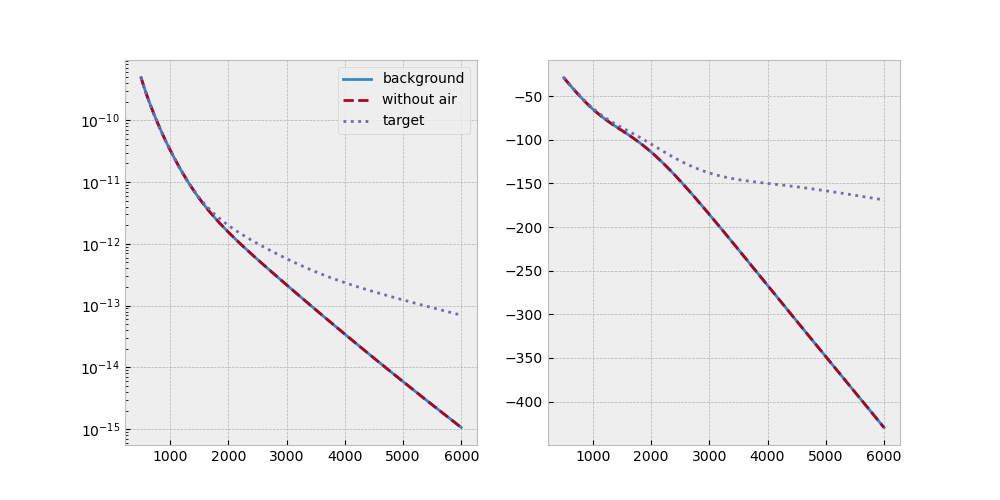

In [3]:
off = np.linspace(2000, 6000, 41)
off = np.linspace(500, 6000, 101)

src = (-100, 100, 0, 0, -2950, -2950)
frequency = 0.5

inp = {
    'src': src,
    'rec': (off, off*0, -3000, 0, 0),
    'depth': [0, -3000, -4000, -4200],
    'freqtime': frequency,
    'srcpts': 5,
    'verb': 1,
}

resp1 = empymod.bipole(res=[2e14, 0.3, 1, 1, 1], **inp)
resp2 = empymod.bipole(res=[0.3, 0.3, 1, 1, 1], **inp)
resp3 = empymod.bipole(res=[2e14, 0.3, 1, 100, 1], **inp)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

ax1.plot(off, resp1.amp(), label='background')
ax1.plot(off, resp2.amp(), '--', label='without air')
ax1.plot(off, resp3.amp(), ':', label='target')
ax1.set_yscale('log')
ax1.legend()

ax2.plot(off, resp1.pha(deg=True), label='background')
ax2.plot(off, resp2.pha(deg=True), '--', label='without air')
ax2.plot(off, resp3.pha(deg=True), ':', label='target')

## emg3d

In [4]:
hx = np.ones(80)*200
hy = np.ones(32)*400
hz = np.ones(40)*200
grid = emg3d.TensorMesh([hx, hy, hz], origin=(-5100, -6600, -8000))
grid

TensorMesh: 102,400 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     80     -5,100.00     10,900.00    200.00    200.00    1.00
   y     32     -6,600.00      6,200.00    400.00    400.00    1.00
   z     40     -8,000.00          0.00    200.00    200.00    1.00

In [6]:
res = np.ones(grid.shape_cells)
res[:, :, grid.cell_centers_z > -3000] = 0.3
res[:, :, (grid.cell_centers_z > -4200) & (grid.cell_centers_z < -4000)] = 100

In [7]:
model = emg3d.Model(grid, property_x=res, mapping='Resistivity')
model

Model: resistivity; isotropic; 80 x 32 x 40 (102,400)

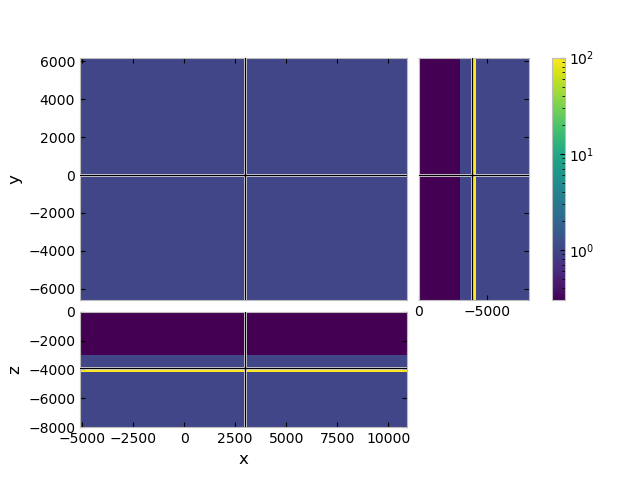

In [9]:
grid.plot_3d_slicer(model.property_x, pcolor_opts={'norm': LogNorm(vmin=0.3, vmax=100)})

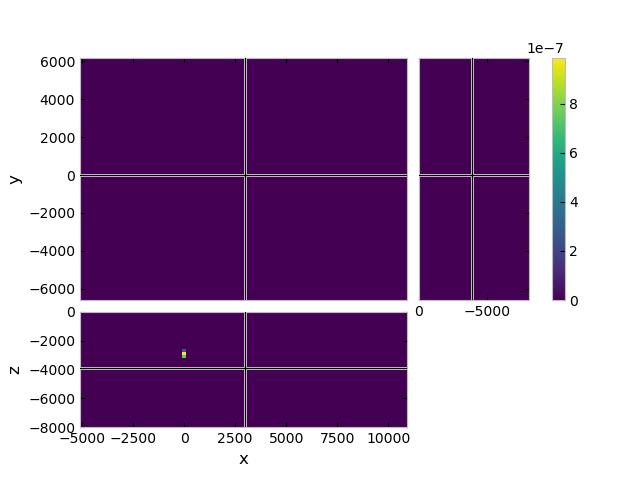

In [32]:
sfield = emg3d.fields.get_source_field(grid, source=src, frequency=frequency)
sfield = emg3d.fields.get_source_field(grid, source=(0, 0, -2950, 0, 0), frequency=frequency)
grid.plot_3d_slicer(sfield.fx.ravel('F'), view='abs', v_type='Ex',)

In [33]:
efield = emg3d.solve(model, sfield, verb=4)


:: emg3d START :: 21:31:29 :: v1.8.1

   MG-cycle       : 'F'                 sslsolver : 'bicgstab'
   semicoarsening : True [1 2 3]        tol       : 1e-06
   linerelaxation : True [4 5 6]        maxit     : 50 (3)
   nu_{i,1,c,2}   : 0, 2, 1, 2          verb      : 4
   Original grid  :  80 x  32 x  40     => 102,400 cells
   Coarsest grid  :   5 x   2 x   5     => 50 cells
   Coarsest level :   4 ;   4 ;   3   

   [hh:mm:ss]  rel. error            solver              MG          l s

       h_
      2h_ \                  /
      4h_  \          /\    / 
      8h_   \    /\  /  \  /  
     16h_    \/\/  \/    \/   

   [21:31:30]   3.627e-03  after                       1 F-cycles    4 1
   [21:31:32]   8.866e-04  after                       2 F-cycles    5 2
   [21:31:33]   3.273e-05  after                       3 F-cycles    6 3
   [21:31:35]   7.365e-06  after                       4 F-cycles    4 1
   [21:31:36]   3.896e-06  after                       5 F-cycles    5 2
   [

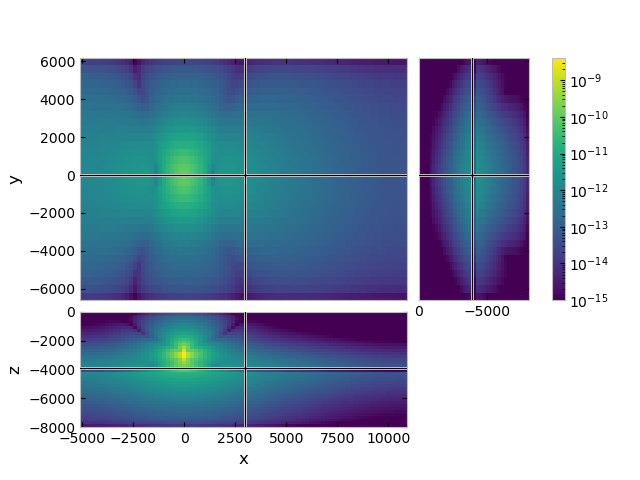

In [37]:
grid.plot_3d_slicer(
        efield.fx.ravel('F'), view='abs', v_type='Ex',
        pcolor_opts={'norm': LogNorm(vmin=1e-15)}
)

In [38]:
resp4 = efield.get_receiver((off, off*0, -3000, 0, 0), 'linear')

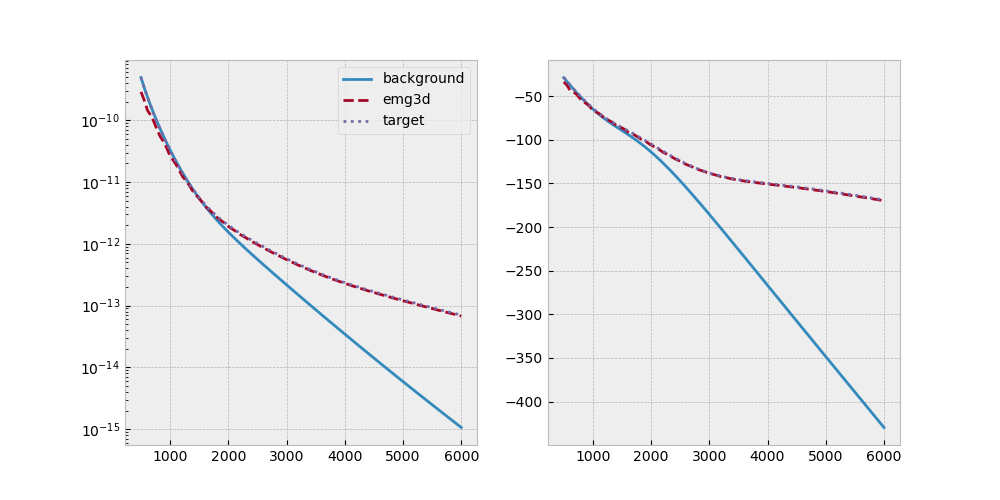

In [39]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

ax1.plot(off, resp1.amp(), label='background')
ax1.plot(off, resp4.amp(), '--', label='emg3d')
ax1.plot(off, resp3.amp(), ':', label='target')
ax1.set_yscale('log')
ax1.legend()

ax2.plot(off, resp1.pha(deg=True), label='background')
ax2.plot(off, resp4.pha(deg=True), '--', label='emg3d')
ax2.plot(off, resp3.pha(deg=True), ':', label='target')

In [76]:
res2 = np.ones(grid.shape_cells)
res2[:, :, grid.cell_centers_z > -3000] = 0.3
res2 = res2.ravel('F')

xx = (grid.cell_centers[:, 0] >= 0) & (grid.cell_centers[:, 0] <= 6000)
yy = abs(grid.cell_centers[:, 1]) <= 500
zz = (grid.cell_centers[:, 2] > -4200)*(grid.cell_centers[:, 2] < -4000)

res2[xx*yy*zz] = 100.  # Target resistivity

model2 = emg3d.Model(grid, property_x=res2, mapping='Resistivity')


/home/dtr/mambaforge/envs/houston23-mc3/lib/python3.10/site-packages/discretize/mixins/mpl_mod.py:737: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


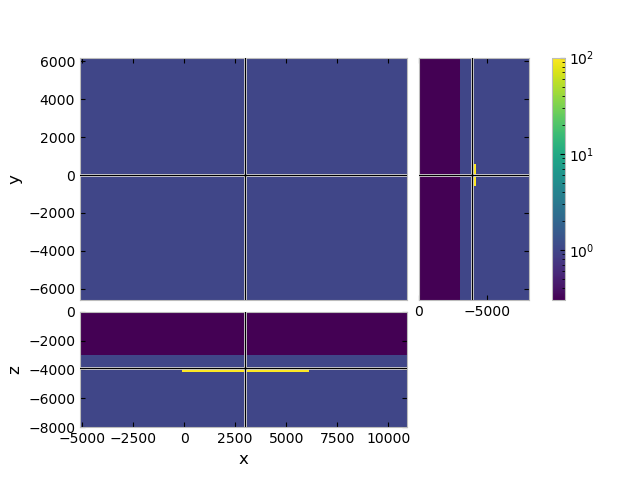

In [77]:
grid.plot_3d_slicer(model2.property_x, pcolor_opts={'norm': LogNorm(vmin=0.3, vmax=100)})

In [82]:
sfield = emg3d.fields.get_source_field(grid, source=(0, 0, -2950, 0, 0), frequency=frequency)
efield2 = emg3d.solve(model2, sfield, verb=2)

:: emg3d :: 2.0e-07; 1(5); 0:00:07; CONVERGED


In [83]:
resp5 = efield2.get_receiver((off, off*0, -3000, 0, 0), 'linear')

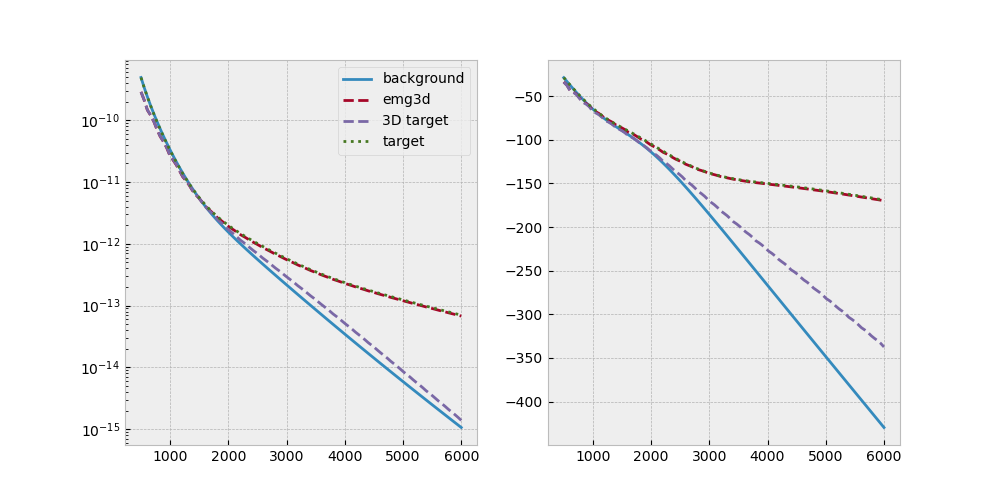

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

ax1.plot(off, resp1.amp(), label='background')
ax1.plot(off, resp4.amp(), '--', label='emg3d')
ax1.plot(off, resp5.amp(), '--', label='3D target')
ax1.plot(off, resp3.amp(), ':', label='target')
ax1.set_yscale('log')
ax1.legend()

ax2.plot(off, resp1.pha(deg=True), label='background')
ax2.plot(off, resp4.pha(deg=True), '--', label='emg3d')
ax2.plot(off, resp5.pha(deg=True), '--', label='3D target')
ax2.plot(off, resp3.pha(deg=True), ':', label='target')

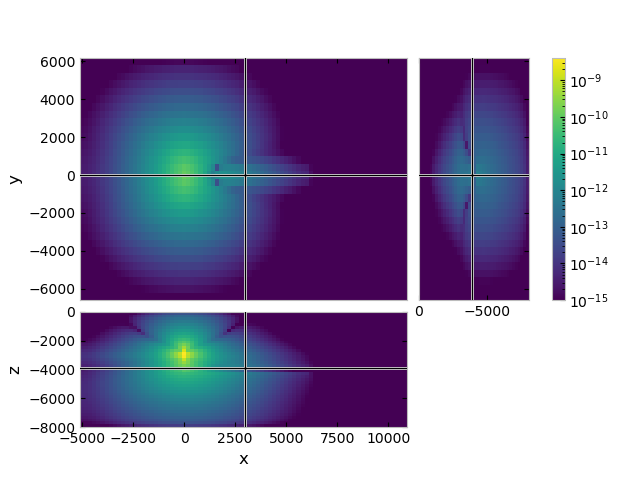

In [85]:
grid.plot_3d_slicer(
        efield2.fx.ravel('F'), view='abs', v_type='Ex',
        pcolor_opts={'norm': LogNorm(vmin=1e-15)}
)

In [ ]:
# => Simulation example

In [79]:
emg3d.Report()

--------------------------------------------------------------------------------
  Date: Sat Feb 11 21:49:41 2023 CET

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:20:04) [GCC
  11.3.0]

             numpy : 1.23.5
             scipy : 1.10.0
             numba : 0.56.4
             emg3d : 1.8.1
           empymod : 2.2.1
            xarray : 2023.2.0
        discretize : 0.8.3
              h5py : 3.8.0
        matplotlib : 3.6.3
              tqdm : 4.64.1
           IPython : 8.9.0
--------------------------------------------------------------------------------